# Analysis of ensembles

In [1]:
import pandas
import matplotlib.pyplot as plt
import geopandas
from gerrychain import Graph, Partition, updaters

In [2]:
gdf = geopandas.read_file("../shapefiles/chicago_precincts_economic.shp")
current_plan = gdf.groupby("ward").sum()
current_partition = Partition(Graph.from_geodataframe(gdf), gdf["ward"], {"cut_edges": updaters.cut_edges})

C:\Users\MGGG\Miniconda3\envs\max\lib\site-packages\gerrychain-0.2.7+98.gbf11fe5-py3.7.egg\gerrychain\graph\adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(410, 1381), (410, 717), (26, 410)}


## Finding interesting plans

In [99]:
def population_deviation(data):
    first_plan = data[data["step"] == 0]
    ideal = first_plan["TOTPOP"].sum() / len(first_plan)
    deviation = abs(data["TOTPOP"] - ideal) / ideal
    return deviation

In [16]:
def majority_black_wards(data):
    number_majority_black = (data["NH_BLACK"] / data["TOTPOP"] > 0.5)
    return number_majority_black

In [17]:
def segregated(data):
    groups = ["NH_BLACK", "NH_WHITE", "NH_ASIAN", "HISP"]
    return data[groups].apply(lambda x: (x / data["TOTPOP"]) > 0.5).any(axis=1)

In [18]:
def compactness(plans):
    return plans["cut_edges"].min()

In [19]:
def all_households(df):
    return df[[ 'LESS_10K', '10K_15K', '15K_20K', '20K_25K', '25K_30K', '30K_35K',
       '35K_40K', '40K_45K', '45K_50K', '50K_60K', '60K_75K', '75K_100K',
       '100K_125K', '125K_150K', '150K_200K', '200K_MORE']].sum(axis=1)

In [20]:
def below_20k(df):
    return df[[ 'LESS_10K', '10K_15K', '15K_20K']].sum(axis=1)

In [21]:
def above_150k(df):
    return df[['150K_200K', '200K_MORE']].sum(axis=1)

In [22]:
def has_concentrated_wealth(df):
    return ((above_150k(df) / all_households(df)) > 0.25)

def has_concentrated_poverty(df):
    return ((below_20k(df) / all_households(df)) > 0.25)

def has_concentrated_wealth_or_poverty(df):
    return has_concentrated_wealth(df) | has_concentrated_poverty(df)

In [39]:
def groups_over_threshold(data, threshold):
    groups = ["NH_BLACK", "NH_WHITE", "NH_ASIAN", "HISP"]
    return data[groups].apply(lambda x: (x / data["TOTPOP"]) > threshold).sum(axis=1)

In [83]:
def multiracial(data, threshold=0.25):
    over_threshold = groups_over_threshold(data, threshold)
    return (over_threshold >= 3) | (over_threshold == 0)

In [40]:
def hypersegregated(data, threshold=0.25):
    return groups_over_threshold(data, threshold) == 1

In [7]:
df = pandas.read_csv("../ensembles/prec50/results.csv")

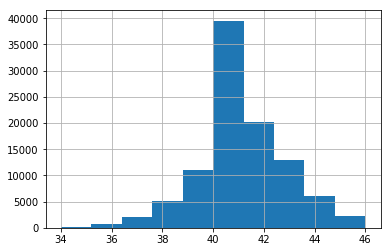

In [14]:
segregated(df).groupby(df["step"]).sum().hist()

## Analyzing outcomes

### Loading the projected outcomes

In [15]:
df50x1 = pandas.read_csv("../projection/projection_50x1.csv")
df10x5 = pandas.read_csv("../projection/projection_10x5.csv")
df10x3 = pandas.read_csv("../projection/projection_10x3.csv")
df10x3_CA = pandas.read_csv("../projection/projection_10x3_CA.csv")
df10x5_CA = pandas.read_csv("../projection/projection_10x5_CA.csv")

### Projected number of city council seats

In [16]:
groups = ['Asian', 'Black', 'Hispanic', 'White']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D126601D0>,
      dtype=object)

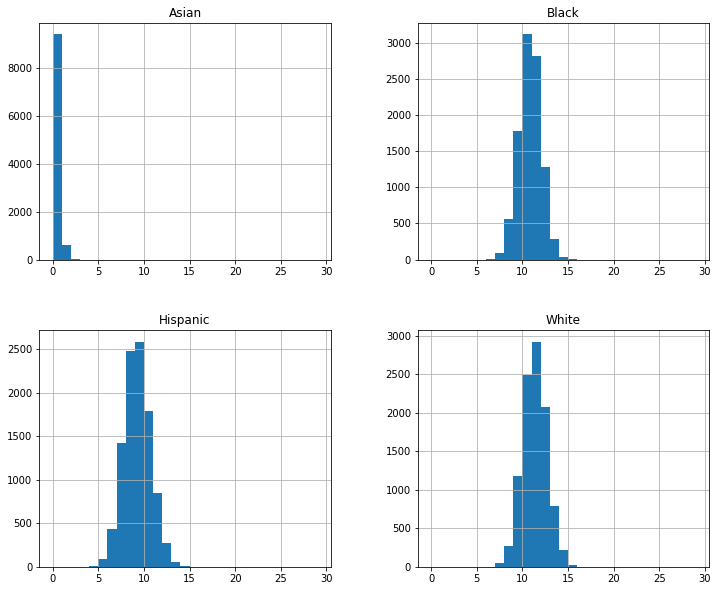

In [17]:
df10x3[groups].hist(figsize=(12,10), bins=list(range(30)))


### Average outcomes

In [18]:
means = pandas.DataFrame({"50x1": df50x1[groups].mean(), "10x5": df10x5[groups].mean(), "10x3": df10x3[groups].mean(), "10x5_CA": df10x5_CA[groups].mean(), "10x3_CA": df10x3_CA[groups].mean()})

In [19]:
means

,50x1,10x5,10x3,10x5_CA,10x3_CA
Asian,0.4472,0.3421,0.0625,0.2251,0.0318
Black,15.6336,16.4632,10.3181,16.8474,10.7753
Hispanic,14.1536,15.6148,8.7613,15.6802,8.8673
White,19.7656,17.5799,10.8581,17.2473,10.3256


In [20]:
means.to_csv("../projection/means.csv")

### City-wide

In [21]:
first_plan = df[df["step"] == 0]

In [167]:
deviation.groupby(df["step"]).max().min()

0.041221472097357735

In [26]:
# citywide_below20k
below_20k(first_plan).sum() / all_households(first_plan).sum()

0.21333095756908763

In [140]:
# citywide_over200k
above_200k(first_plan).sum() / all_households(first_plan).sum()

### Comparing to current plan

In [78]:
current_plan = gdf.groupby("ward").sum()

In [65]:
# Number of wards with concentrated wealth or poverty, over the ensemble
def hist_with_line_for_current(function, df=df, current_plan=current_plan, bins=range(18,31), **kwargs):
    fig, ax = plt.subplots()
    function(df).groupby(df["step"]).sum().hist(bins=bins, ax=ax, **kwargs)
    ax.axvline(function(current_plan).sum(), color="r")
    return fig, ax

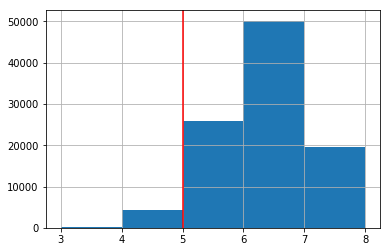

In [58]:
hist_with_line_for_current(has_concentrated_wealth, bins=range(3,9))
plt.show()

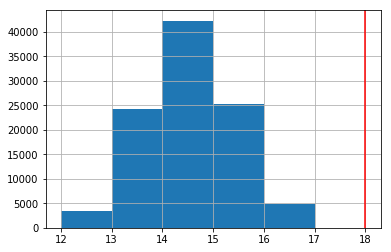

In [61]:
hist_with_line_for_current(majority_black_wards, bins=range(12,18))
plt.show()

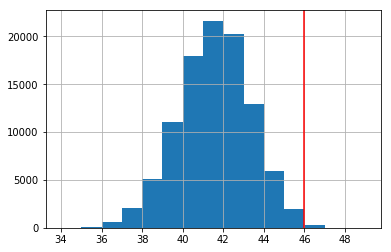

In [59]:
hist_with_line_for_current(segregated, bins=range(34,50))
plt.show()

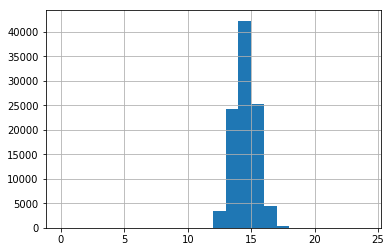

In [55]:
majority_black_wards(df).hist(bins=list(range(25)))
plt.show()

### Segregation and hypersegregation

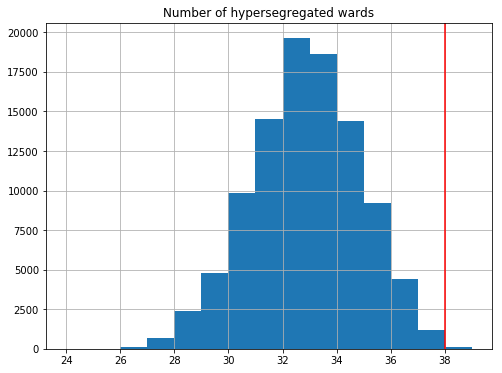

In [77]:
fig, ax = hist_with_line_for_current(hypersegregated, df=df, bins=range(24, 40), figsize=(8,6))
ax.set_xticks(list(range(24, 40, 2)))
ax.set_title("Number of hypersegregated wards")
plt.savefig("../figures/prec50_hypersegregated.png")
plt.show()

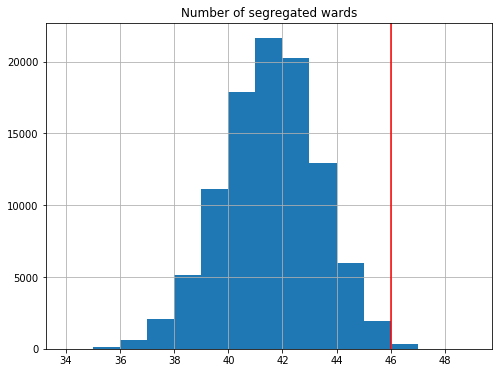

In [78]:
fig, ax = hist_with_line_for_current(segregated, df=df, bins=range(34, 50), figsize=(8,6))
ax.set_xticks(list(range(34, 50, 2)))
ax.set_title("Number of segregated wards")
fig.savefig("../figures/prec50_segregated.png")
plt.show()

## Finding interesting plans

1. Least-segregated
2. Current plan
3. Most majority-black
4. Fewest concentrated poverty

#### 50x1

In [97]:
segregated(df).groupby(df["step"]).sum().min()

34.0

In [96]:
majority_black_wards(df).groupby(df["step"]).sum().max()

17.0

In [95]:
has_concentrated_poverty(df).groupby(df["step"]).sum().min()

13.0

#### 10xM

In [24]:
prec10 = pandas.read_csv("../ensembles/prec10/results.csv")

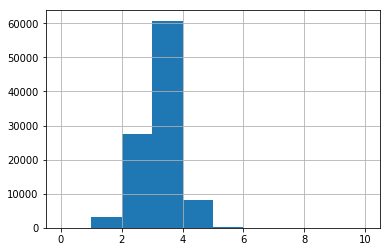

In [86]:
hypersegregated(prec10, threshold=1/6).groupby(prec10["step"]).sum().hist(bins=range(0, 11))

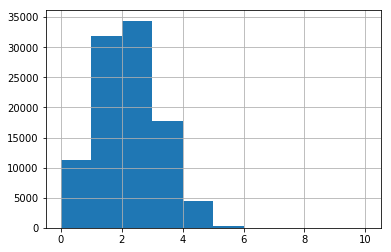

In [85]:
multiracial(prec10, threshold=1/6).groupby(prec10["step"]).sum().hist(bins=range(0,11))

In [89]:
multiracial(prec10, threshold=1/6).groupby(prec10["step"]).sum().idxmax()

55213

In [94]:
has_concentrated_wealth_or_poverty(prec10).groupby(prec10["step"]).sum().idxmin()

205

In [102]:
population_deviation(prec10).groupby(prec10["step"]).max().min()

0.017025676427120568

In [126]:
segregated(prec10).groupby(prec10["step"]).sum().min()

3.0

In [ ]:
segregated(prec10)

#### 10xM CA

In [127]:
ca10 = pandas.read_csv("../ensembles/ca10/results.csv")

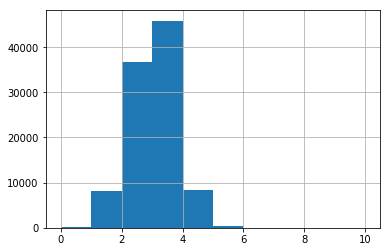

In [128]:
hypersegregated(ca10, threshold=1/6).groupby(ca10["step"]).sum().hist(bins=range(0, 11))

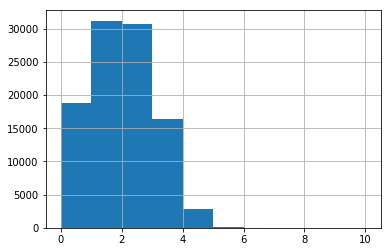

In [133]:
multiracial(ca10, threshold=1/6).groupby(ca10["step"]).sum().hist(bins=range(0,11))

In [134]:
multiracial(ca10, threshold=1/6).groupby(ca10["step"]).sum().idxmax()

25218

In [137]:
has_concentrated_wealth_or_poverty(ca10).groupby(ca10["step"]).sum().idxmin()

5848

In [141]:
population_deviation(ca10).groupby(ca10["step"]).max().min()

0.016237681479992973

In [153]:
segregated(ca10).groupby(ca10["step"]).sum().idxmin()

1042

In [144]:
hypersegregated(ca10, 1/6).groupby(ca10["step"]).sum().idxmin()

937

In [157]:
hypersegregated(ca10, 1/4).groupby(ca10["step"]).sum().min()

3.0